# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)

# Эпизод 1 
## Import

In [1]:
# Мы должны убедиться, что GPU включен в notebook
# сообщение, которое мы хотим увидеть: CUDA is available!  Training on GPU ...
# 
# если мы получили обратное сообщение, то нужно включить GPU:
# из Меню > Среда выполнения > сменить среду выполнения > Аппаратный ускоритель > GPU

import torch
import torch.nn as nn
import albumentations as A
from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader 

import numpy as np
import PIL
import pickle
from PIL import Image
from skimage import io
from tqdm import tqdm, tqdm_notebook
from pathlib import Path

from matplotlib import colors, pyplot as plt
%matplotlib inline


# в sklaern не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not abailable. Training on CPU ...')
else:
  print('CUDA is available. Training on GPU ...')

CUDA is available. Training on GPU ...


In [2]:
!nvidia-smi
torch.cuda.is_available()

Fri Aug  5 08:50:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

# Эпизод 2 <br> 
### Загрузка данных

In [3]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [4]:
from torchvision.transforms.transforms import ToTensor
class SimpsonsDataset(Dataset):
  """
  Датасет с картинками, который параллельно подгружает их из папок
  производит скалирование и превращение в торчевые тензоры
  """
  def __init__(self, files, mode, full_transform):
    super().__init__()
    # список файлов для загрузки
    self.files = sorted(files)
    # режим работы
    self.mode = mode
    # режим трансформации данных
    self.full_transform = full_transform

    if self.mode not in DATA_MODES:
      print(f'{self.mode} is not correct; correct modes: {DATA_MODES}')
      raise NameError

    self.len_ = len(self.files)

    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(self.label_encoder, le_dump_file)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
      # для преобразования изображений в тензоры PyTorch и нормализации входа
      if self.full_transform:
        if self.mode == 'train':
          transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomResizedCrop(RESCALE_SIZE-32),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        if self.mode == 'val':
          transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),                             
            transforms.CenterCrop(RESCALE_SIZE-32),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
          ])
        if self.mode == 'test':
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
          ])
      if self.full_transform is False:
        if self.mode == 'train':
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        if self.mode == 'val':
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
          ])
        if self.mode == 'test':
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
          ])
      x = self.load_sample(self.files[index])
      if self.full_transform:
        x = transform(x)
      if self.full_transform is False:
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
      if self.mode == 'test':
          return x
      else:
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
!unzip /content/gdrive/MyDrive/'journey-springfield (3)'.zip
from IPython.display import clear_output
clear_output()

In [8]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [9]:
from sklearn.model_selection import train_test_split


train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [10]:
data = np.unique(train_val_labels, return_counts=True)
data_list = []
"""
[
 {'abraham': {'predicted': 1,
              'true': 913}
  },
  ...

]
"""
for key, values in zip(data[0], data[1]):
  character = {key: {'true_amount': values, 
                     'predicted': 0}}
  data_list.append(character)

coder_dict = {id: key for id, key in enumerate(np.unique(data[0]))} # кодируем имена героев в числа

def get_predicted(preds):
  for pred in preds:
    for statistics in data_list[pred].values():
      statistics['predicted'] += 1

# Эпизод 3
## Анализ данных

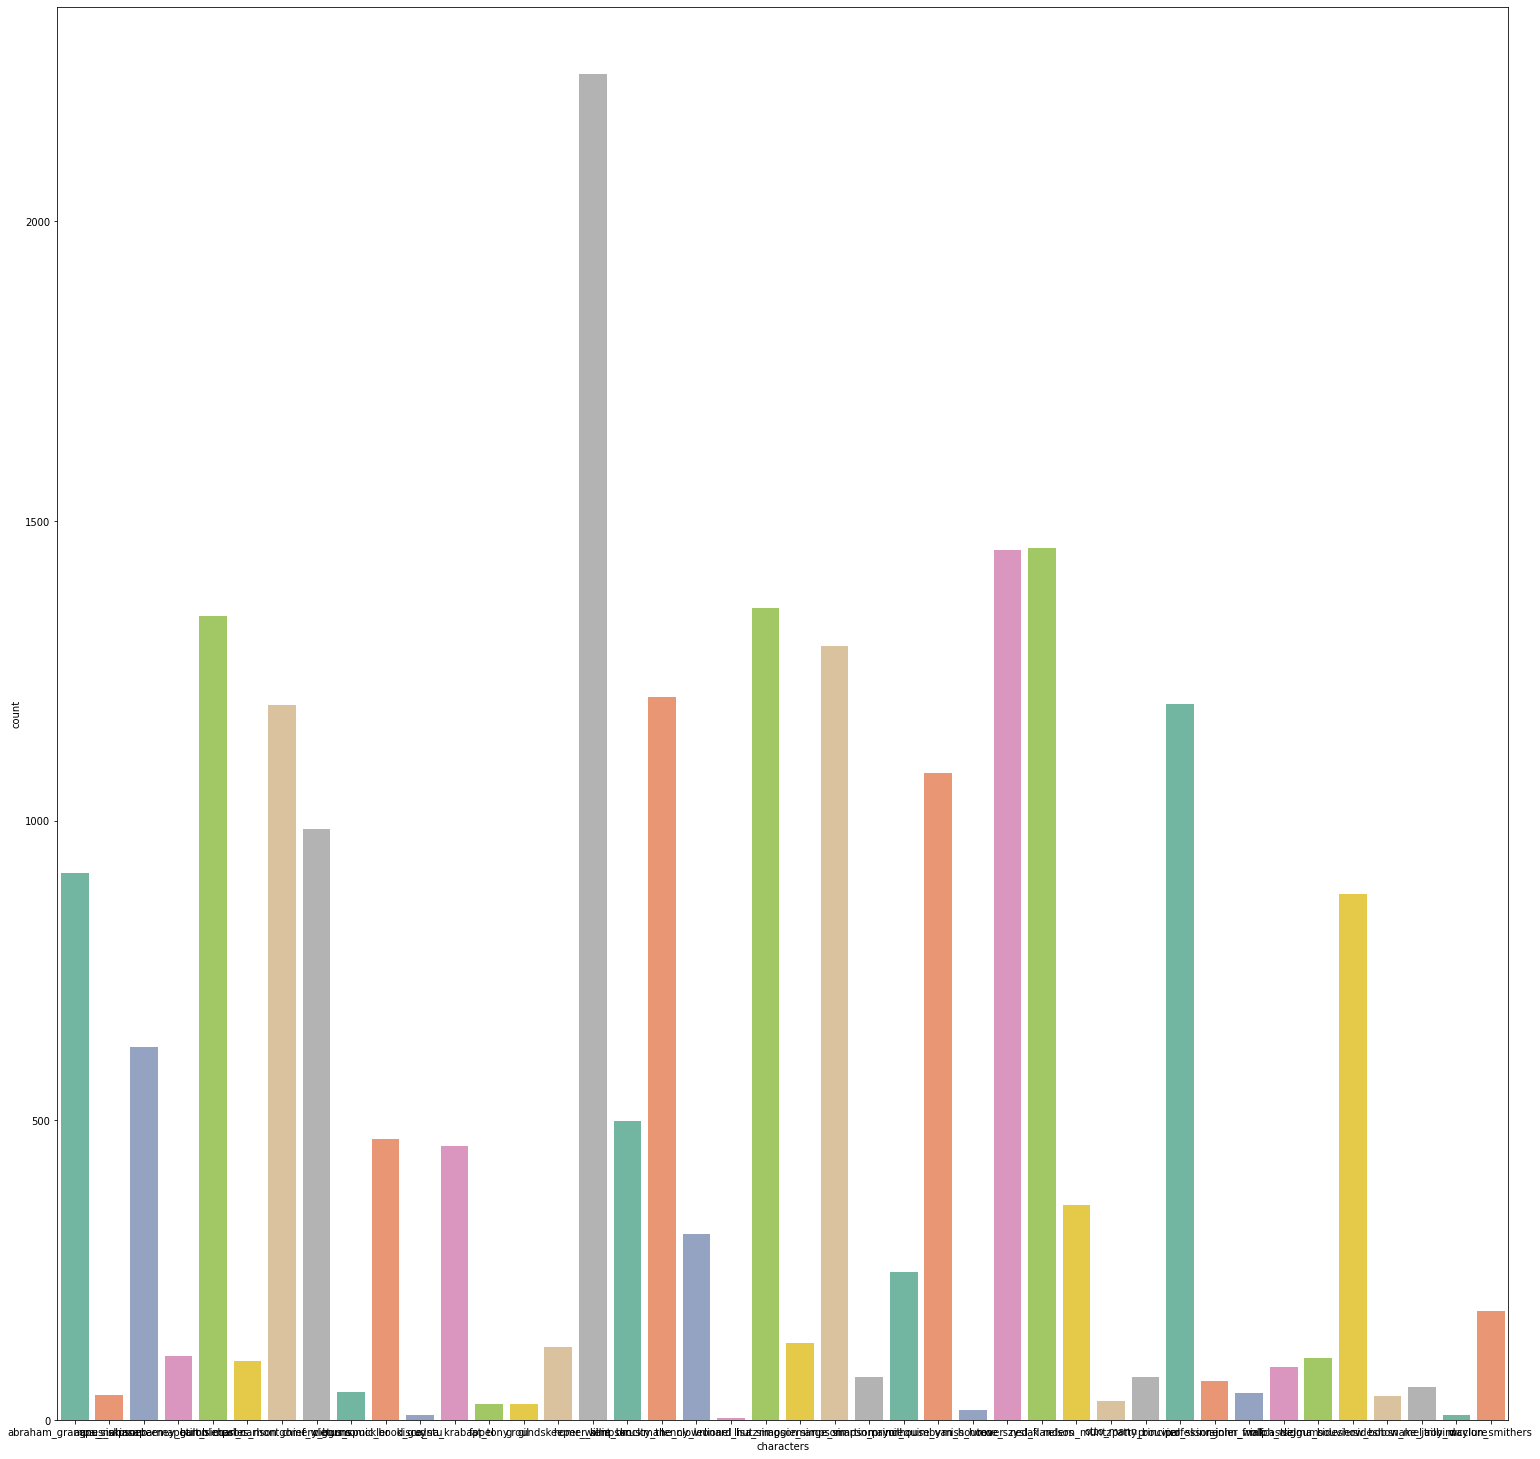

Всего классов: 42
Всего объектов обучающей выборки: 20933
герой: abraham_grampa_simpson кол-во объектов: 913 процент от всего набора данных: 4.36%
герой: agnes_skinner кол-во объектов: 42 процент от всего набора данных: 0.201%
герой: apu_nahasapeemapetilon кол-во объектов: 623 процент от всего набора данных: 2.98%
герой: barney_gumble кол-во объектов: 106 процент от всего набора данных: 0.506%
герой: bart_simpson кол-во объектов: 1342 процент от всего набора данных: 6.41%
герой: carl_carlson кол-во объектов: 98 процент от всего набора данных: 0.468%
герой: charles_montgomery_burns кол-во объектов: 1193 процент от всего набора данных: 5.7%
герой: chief_wiggum кол-во объектов: 986 процент от всего набора данных: 4.71%
герой: cletus_spuckler кол-во объектов: 47 процент от всего набора данных: 0.225%
герой: comic_book_guy кол-во объектов: 469 процент от всего набора данных: 2.24%
герой: disco_stu кол-во объектов: 8 процент от всего набора данных: 0.0382%
герой: edna_krabappel кол-во объект

In [11]:
from collections import Counter
import pandas as pd
import seaborn as sns


data_counter = Counter(train_val_labels)
data_dict = {'characters' : train_val_labels}
data_dict = {'' + str(i): characters for characters, i in zip(data_dict['characters'], 
                                                              range(len(data_dict['characters'])))}
data = pd.DataFrame(list(data_dict.values()), columns=['characters'])

plt.figure(figsize=(26, 26))
sns.countplot(data=data, x='characters', palette='Set2')
plt.show()

print(f'Всего классов: {len(np.unique(train_val_labels))}')
num_train_object = len(train_val_labels)
print(f'Всего объектов обучающей выборки: {num_train_object}')
data_procent = {character: [value/num_train_object, value] for character, value in data_counter.items()}
for character, value in data_procent.items():
  print(f'герой: {character} кол-во объектов: {value[1]} процент от всего набора данных: {value[0]*100:.3}%')

42 героя у нас в датасете, у каждого героя разное количество картинок.<br>
Классы получились несбалансированными, у кого-то 1454 картинок, а у кого-то всего 3. <br>
Из-за этого класс с меньшими картинками имеет меньший шанс быть предсказаным. <br>
Проблему с дисбалансом мы решим после проверки дефолтной cnn.

In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=False)

In [13]:
def register_extension(id, extension): 
  Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

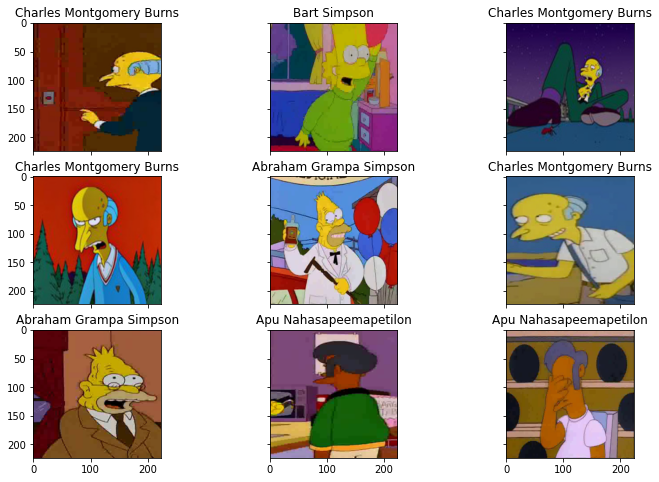

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 8), 
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(),
          title=img_label,plt_ax=fig_x)

# Эпизод 4
## Построение нейросети


In [15]:
class SimpleCnn(nn.Module):
  def __init__(self, n_classes, full_transform):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.full_transform = full_transform
    if self.full_transform:
      self.out = nn.Linear(96 * 4 * 4, n_classes)
    if self.full_transform == False:
      self.out = nn.Linear(96 * 5 * 5, n_classes)
    #self.full_transform = full_transform
    #self.n_classes = n_classes

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    #if self.full_transform:
      #vector_shape = x.shape[1] * x.shape[2] * x.shape[3]
      #print(vector_shape)
      #self.out = nn.Linear(96 * 4 * 4, 42)  
    x = x.view(x.size(0), -1)
    logits = self.out(x)
    return logits

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer, epoch_last, scheduler):
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0
  scheduler.step()

  for inputs, labels in tqdm_notebook(train_loader):
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    if epoch_last:
      get_predicted(preds) # добавляем к классу одно предсказание
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data
  return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion, epoch_last, scheduler):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0
  scheduler.step()

  for inputs, labels in val_loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)
      if epoch_last:
        get_predicted(preds) # добавляем к классу одно предсказание
    
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_size += inputs.size(0)
  val_loss = running_loss / processed_size
  val_acc = running_corrects.double() / processed_size
  return val_loss, val_acc  

In [18]:
def train(train_files, val_files, model, epochs, batch_size, sampler=None, freeze=False):
  if sampler is not None:
    shuffle_flag=False
  else:
    shuffle_flag=True
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_flag, sampler=sampler)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  history = []
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
  
  with tqdm(desc='epoch', total=epochs) as pbar_outer:
    if freeze == True:
      opt = torch.optim.Adam(list(model.features[:-layers_to_unfreeze].parameters()) +
                             list(model.classifier.parameters()), lr=0.001)
    if freeze == False:  
      opt = torch.optim.Adam(model.parameters(), lr=0.001)
    if freeze == 'ResNet':
      opt = torch.optim.Adam(list(model.layer4.parameters()) + list(model.fc.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

    for epoch in range(epochs):
      if epoch == epochs-1:
        epoch_last = True
      else:
        epoch_last = False
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, epoch_last, exp_lr_scheduler)
      print('loss', train_loss)

      val_loss, val_acc = eval_epoch(model, val_loader, criterion, epoch_last, exp_lr_scheduler)
      history.append((train_loss, train_acc, val_loss, val_acc))

      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
  return history

In [19]:
def predict(model, test_loader):
  with torch.no_grad():
    logits = []

    for inputs in test_loader:
      inputs = inputs.to(DEVICE)
      model.eval()
      outputs = model(inputs).cpu()
      logits.append(outputs)

  probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
  return probs

In [20]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes, full_transform=False).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

# Эпизод 5
##Обучение сети

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=False)

train_dataset = SimpsonsDataset(train_files, mode='train', full_transform=False)

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/246 [00:00<?, ?it/s]

loss 2.5670817606661287


epoch:  50%|█████     | 1/2 [02:24<02:24, 144.38s/it]


Epoch 001 train_loss: 2.5671     val_loss 1.9056 train_acc 0.2880 val_acc 0.4889


  0%|          | 0/246 [00:00<?, ?it/s]

loss 1.5170802283920342


epoch: 100%|██████████| 2/2 [04:47<00:00, 143.51s/it]


Epoch 002 train_loss: 1.5171     val_loss 1.2530 train_acc 0.5891 val_acc 0.6590


Посмотрим сколько раз каждый класс был предсказан

In [ ]:
data_list

[{'abraham_grampa_simpson': {'predicted': 916, 'true_amount': 913}},
 {'agnes_skinner': {'predicted': 4, 'true_amount': 42}},
 {'apu_nahasapeemapetilon': {'predicted': 809, 'true_amount': 623}},
 {'barney_gumble': {'predicted': 52, 'true_amount': 106}},
 {'bart_simpson': {'predicted': 1319, 'true_amount': 1342}},
 {'carl_carlson': {'predicted': 15, 'true_amount': 98}},
 {'charles_montgomery_burns': {'predicted': 1258, 'true_amount': 1193}},
 {'chief_wiggum': {'predicted': 1079, 'true_amount': 986}},
 {'cletus_spuckler': {'predicted': 12, 'true_amount': 47}},
 {'comic_book_guy': {'predicted': 358, 'true_amount': 469}},
 {'disco_stu': {'predicted': 0, 'true_amount': 8}},
 {'edna_krabappel': {'predicted': 454, 'true_amount': 457}},
 {'fat_tony': {'predicted': 5, 'true_amount': 27}},
 {'gil': {'predicted': 3, 'true_amount': 27}},
 {'groundskeeper_willie': {'predicted': 27, 'true_amount': 121}},
 {'homer_simpson': {'predicted': 2310, 'true_amount': 2246}},
 {'kent_brockman': {'predicted': 4

Видно, что классы с меньшим количеством картинок были плохо предсказаны, где-то по нулям

Построим кривую обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

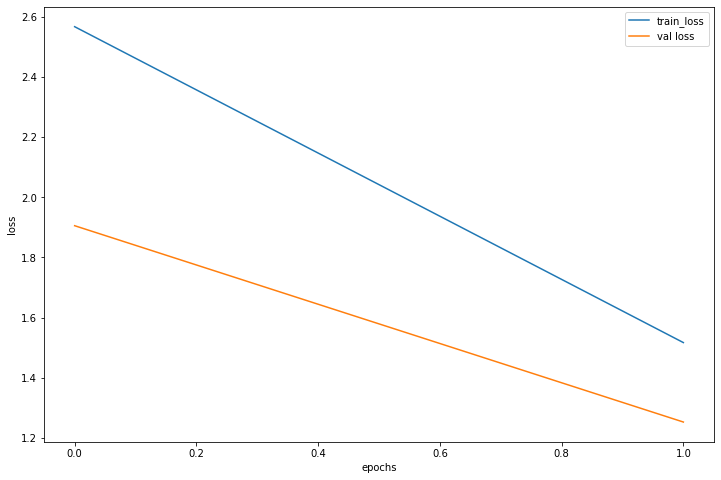

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

Здесь можно сказать, что явно не хватает эпох, так как прямые еще стремятся к уменьшению 

## Работа с предсказаниями

Реализуем предсказание для одной картинки

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
  """ Предсказание для одной картинки """
  with torch.no_grad():
    inputs = inputs.to(DEVICE)
    model.eval()
    logit = model(inputs).cpu()
    probs = torch.nn.functional.softmax(logit, dim=-1)
  return probs

In [47]:
label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

True label = 15
True label name = homer_simpson
Predict = 6
Predict name = charles_montgomery_burns


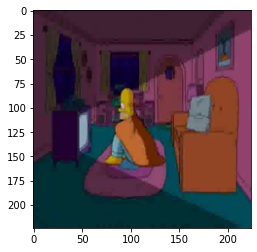

In [ ]:
random_characters = int(np.random.uniform(0, len(val_dataset)))
ex_img, true_label = val_dataset[random_characters]
probs_img = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))
imshow(ex_img.data.cpu())

pred = torch.argmax(probs_img, 1)

true_label_name = label_encoder.classes_[true_label]
predict_name = label_encoder.classes_[pred]

print(f'True label = {true_label}')
print(f'True label name = {true_label_name}')
print(f'Predict = {pred.item()}')
print(f'Predict name = {predict_name}')

Реализуем предсказание для 20 картинок

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(simple_cnn, imgs)

In [ ]:
y_pred = np.argmax(probs_imgs, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels, y_pred

([0, 2, 6, 0, 6, 4, 4, 0, 4, 4, 4, 0, 0, 0, 0, 0, 4, 0, 4, 6],
 array([37,  2, 37,  0,  6,  4,  4, 29,  4,  6,  4,  0, 28,  0,  0,  0,  4,
         4,  9,  6]))

Посмотрим на f1 score

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.65

Визуализируем уверенность сети в своих предсказаниях

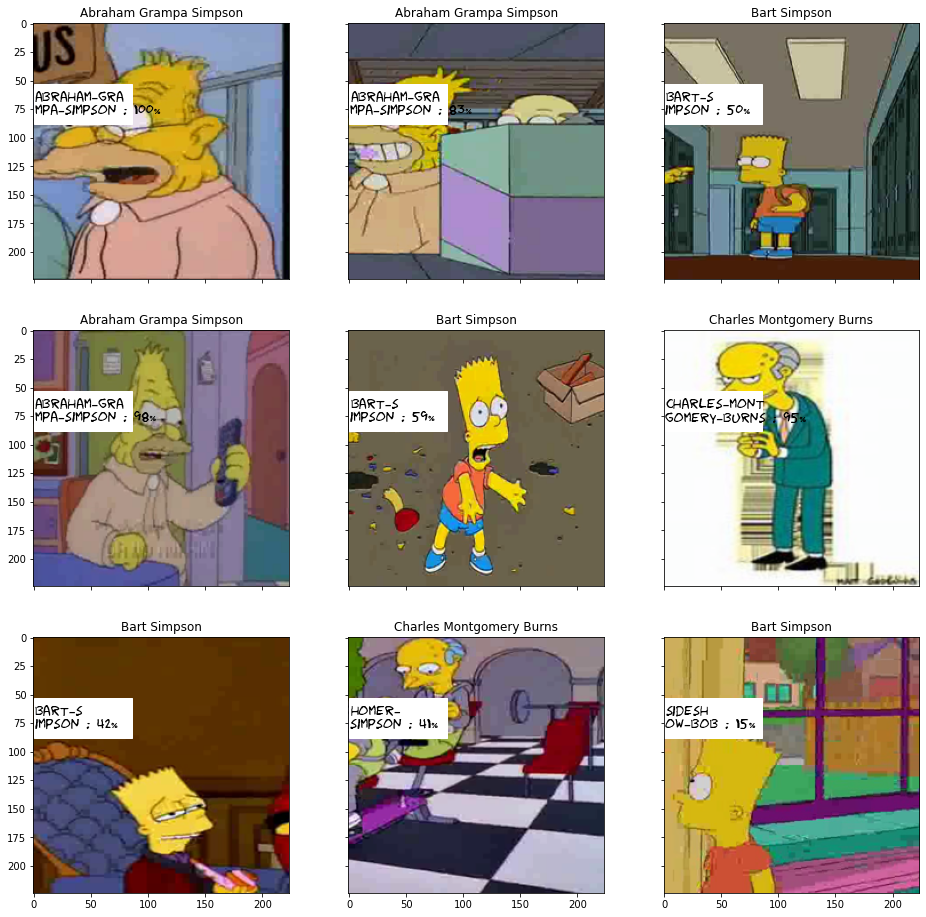

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred.numpy())*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=14, color='black',fontweight='bold')

Оценка f1 простой cnn показала <b>0.55</b> <br>
<b>SimpleCNN:</b> <br>
-optimizer = Adam<br>
-learning rate = 0.001<br>
-sheduler = dont use [x]<br>
-bath size = 64<br>
-epochs = 2<br>
-criterion = nn.CrossEntropyLoss()<br>
-Data Augmentation = dont use [x]<br>
-Дисбаланс классов




## Решим проблему с дисбалансом классов

Метод основан на вероятности появления каждого класса.<br>
Например, класс ned_flanders встречается 1454 раза, а класс lionel_hutz всего 3 раза. Понятно, что lionel_hurtz попросту не будет распознаваться, нужно сделать так, чтобы он появлялся в батчах чаще чем, ned_flanders.<br>
<b>p - вероятность, n - кол-во картинок</b> <br>
$p(ned flanders) = \frac{1}{n} = 0.00068776$ <br>
$p(lionelhurtz) = \frac{1}{n} = 0.033$ <br>

In [21]:
class_sample_count = np.unique(train_val_labels, return_counts=True)[1]
class_sample_count # сколько раз встречается каждый класс

array([ 913,   42,  623,  106, 1342,   98, 1193,  986,   47,  469,    8,
        457,   27,   27,  121, 2246,  498, 1206,  310,    3, 1354,  128,
       1291,   71,  246, 1079,   17, 1452, 1454,  358,   32,   72, 1194,
         65,   45,   89,  103,  877,   40,   55,    8,  181])

In [22]:
data = [path.parent.name for path in train_files]
coder_dict = {key: id for id, key in enumerate(np.unique(data))} # кодируем имена героев в числа
for index, character in enumerate(data): # заменяем имена на числа
  data[index] = coder_dict[character]


weight = 1. / class_sample_count # считаем вес каждого класса 1 / кол-во картинок
samples_weight = weight[data] 
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight)) # создаем sampler для dataloader

## Тестируем модель после попытки установить баланс классов

In [23]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=True)

train_dataset = SimpsonsDataset(train_files, mode='train', full_transform=True)

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes, full_transform=True).to(DEVICE)
print("we will classify :{}".format(n_classes))
#img, label = train_dataset[2078]
#simple_cnn(img.unsqueeze(0))

we will classify :42


In [ ]:
BATCH_SIZE = 128
history2 = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=BATCH_SIZE, sampler=sampler)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/123 [00:00<?, ?it/s]

loss 2.9927250382186306


epoch:  20%|██        | 1/5 [02:02<08:10, 122.58s/it]


Epoch 001 train_loss: 2.9927     val_loss 2.7390 train_acc 0.1384 val_acc 0.2382


  0%|          | 0/123 [00:00<?, ?it/s]

loss 2.563970133046207


epoch:  40%|████      | 2/5 [04:04<06:07, 122.37s/it]


Epoch 002 train_loss: 2.5640     val_loss 2.1552 train_acc 0.2831 val_acc 0.4243


  0%|          | 0/123 [00:00<?, ?it/s]

loss 2.208568079311063


epoch:  60%|██████    | 3/5 [06:06<04:04, 122.27s/it]


Epoch 003 train_loss: 2.2086     val_loss 1.7755 train_acc 0.3856 val_acc 0.5227


  0%|          | 0/123 [00:00<?, ?it/s]

loss 1.9651186656356578


epoch:  80%|████████  | 4/5 [08:13<02:03, 123.99s/it]


Epoch 004 train_loss: 1.9651     val_loss 1.6366 train_acc 0.4633 val_acc 0.5592


  0%|          | 0/123 [00:00<?, ?it/s]

loss 1.9089071898409056


epoch: 100%|██████████| 5/5 [10:16<00:00, 123.25s/it]


Epoch 005 train_loss: 1.9089     val_loss 1.5814 train_acc 0.4816 val_acc 0.5753


In [ ]:
data_list

[{'abraham_grampa_simpson': {'predicted': 1750, 'true_amount': 913}},
 {'agnes_skinner': {'predicted': 4, 'true_amount': 42}},
 {'apu_nahasapeemapetilon': {'predicted': 1776, 'true_amount': 623}},
 {'barney_gumble': {'predicted': 55, 'true_amount': 106}},
 {'bart_simpson': {'predicted': 2172, 'true_amount': 1342}},
 {'carl_carlson': {'predicted': 20, 'true_amount': 98}},
 {'charles_montgomery_burns': {'predicted': 1954, 'true_amount': 1193}},
 {'chief_wiggum': {'predicted': 2068, 'true_amount': 986}},
 {'cletus_spuckler': {'predicted': 12, 'true_amount': 47}},
 {'comic_book_guy': {'predicted': 677, 'true_amount': 469}},
 {'disco_stu': {'predicted': 0, 'true_amount': 8}},
 {'edna_krabappel': {'predicted': 889, 'true_amount': 457}},
 {'fat_tony': {'predicted': 5, 'true_amount': 27}},
 {'gil': {'predicted': 3, 'true_amount': 27}},
 {'groundskeeper_willie': {'predicted': 45, 'true_amount': 121}},
 {'homer_simpson': {'predicted': 5255, 'true_amount': 2246}},
 {'kent_brockman': {'predicted':

In [ ]:
loss, acc, val_loss, val_acc = zip(*history2)

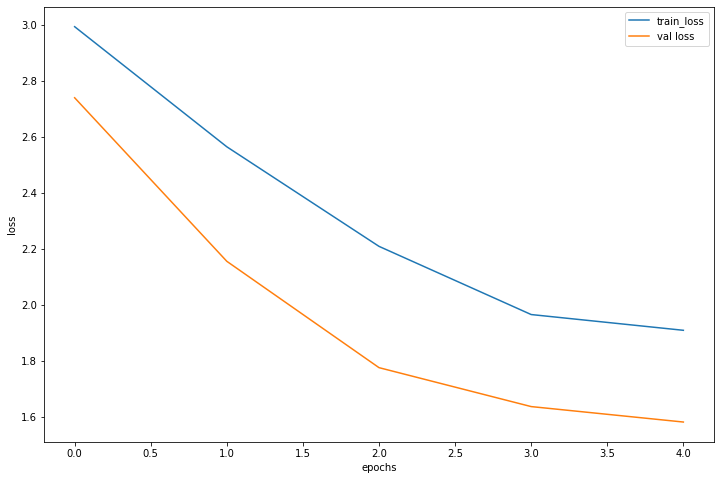

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(simple_cnn, imgs)

In [ ]:
y_pred = np.argmax(probs_imgs, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels, y_pred

([0, 0, 4, 4, 2, 0, 1, 0, 6, 0, 6, 1, 4, 4, 5, 0, 2, 4, 0, 6],
 array([15,  0, 20,  4, 17,  0, 32,  0, 28,  0, 27, 20, 20,  9,  2,  0, 17,
        22, 15,  6]))

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.35

Лучших результатов добиться не получилось, f1 уменьшилось, а малочисленные классы также не распознаются

## Применим метод OverSampling




In [24]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [25]:
len(train_files)

15699

In [26]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files] # классы val

In [27]:
def create_dct_path_labels(train_files, train_labels):
  dct_simpsons = {}
  for label_i in np.unique(train_labels).tolist():
    dct_simpsons[label_i] = []

  for path_i, label_i in zip(train_files, train_labels):
    dct_simpsons[label_i].append(path_i)

  return dct_simpsons

def print_dct(dct_simpsons):
  for key in dct_simpsons:
    print(f'{key}\t{len(dct_simpsons[key])}')

In [28]:
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [29]:
# Дополним картинки классов у которых менее 100 картинок, 
# до 100 картинок в классе
for person in dct_path_train:
  if len(dct_path_train[person]) < 100:
    dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
    dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
    

In [30]:
new_train_files = []

In [31]:
for person in dct_path_train:
  new_train_files.extend(dct_path_train[person])

In [32]:
len(new_train_files)

16895

In [33]:
new_train_label = [path.parent.name for path in new_train_files] # классы train

In [34]:
print_dct(dct_path_train)

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


Теперь все классы имеют минимум 100 картинок

In [35]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=True)
train_dataset = SimpsonsDataset(new_train_files, mode='train', full_transform=True)

In [36]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes, full_transform=True).to(DEVICE)
print("we will classify :{}".format(n_classes))

we will classify :42


In [ ]:
BATCH_SIZE = 128
history2 = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/132 [00:00<?, ?it/s]

loss 3.1770450304301754


epoch:  10%|█         | 1/10 [02:08<19:19, 128.80s/it]


Epoch 001 train_loss: 3.1770     val_loss 2.4769 train_acc 0.1390 val_acc 0.3036


  0%|          | 0/132 [00:00<?, ?it/s]

loss 2.639105087344059


epoch:  20%|██        | 2/10 [04:17<17:11, 128.97s/it]


Epoch 002 train_loss: 2.6391     val_loss 1.8781 train_acc 0.2874 val_acc 0.4838


  0%|          | 0/132 [00:00<?, ?it/s]

loss 2.2167402479838394


epoch:  30%|███       | 3/10 [06:28<15:07, 129.58s/it]


Epoch 003 train_loss: 2.2167     val_loss 1.4922 train_acc 0.4125 val_acc 0.5982


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.945021266124417


epoch:  40%|████      | 4/10 [08:37<12:55, 129.32s/it]


Epoch 004 train_loss: 1.9450     val_loss 1.3568 train_acc 0.4770 val_acc 0.6355


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.9163037172821578


epoch:  50%|█████     | 5/10 [10:46<10:46, 129.25s/it]


Epoch 005 train_loss: 1.9163     val_loss 1.3151 train_acc 0.4906 val_acc 0.6521


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.8584987124312944


epoch:  60%|██████    | 6/10 [12:54<08:35, 128.95s/it]


Epoch 006 train_loss: 1.8585     val_loss 1.2868 train_acc 0.5068 val_acc 0.6578


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.831812448740076


epoch:  70%|███████   | 7/10 [15:04<06:27, 129.29s/it]


Epoch 007 train_loss: 1.8318     val_loss 1.2590 train_acc 0.5098 val_acc 0.6622


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.788298067668374


epoch:  80%|████████  | 8/10 [17:13<04:18, 129.04s/it]


Epoch 008 train_loss: 1.7883     val_loss 1.2468 train_acc 0.5186 val_acc 0.6674


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.7961027846811932


epoch:  90%|█████████ | 9/10 [19:21<02:08, 128.82s/it]


Epoch 009 train_loss: 1.7961     val_loss 1.2412 train_acc 0.5162 val_acc 0.6679


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.7711229100739614


epoch: 100%|██████████| 10/10 [21:30<00:00, 129.03s/it]


Epoch 010 train_loss: 1.7711     val_loss 1.2353 train_acc 0.5248 val_acc 0.6699


In [ ]:
data_list

[{'abraham_grampa_simpson': {'predicted': 2515, 'true_amount': 913}},
 {'agnes_skinner': {'predicted': 35, 'true_amount': 42}},
 {'apu_nahasapeemapetilon': {'predicted': 2663, 'true_amount': 623}},
 {'barney_gumble': {'predicted': 63, 'true_amount': 106}},
 {'bart_simpson': {'predicted': 3473, 'true_amount': 1342}},
 {'carl_carlson': {'predicted': 77, 'true_amount': 98}},
 {'charles_montgomery_burns': {'predicted': 3074, 'true_amount': 1193}},
 {'chief_wiggum': {'predicted': 3197, 'true_amount': 986}},
 {'cletus_spuckler': {'predicted': 43, 'true_amount': 47}},
 {'comic_book_guy': {'predicted': 1015, 'true_amount': 469}},
 {'disco_stu': {'predicted': 132, 'true_amount': 8}},
 {'edna_krabappel': {'predicted': 1335, 'true_amount': 457}},
 {'fat_tony': {'predicted': 71, 'true_amount': 27}},
 {'gil': {'predicted': 35, 'true_amount': 27}},
 {'groundskeeper_willie': {'predicted': 87, 'true_amount': 121}},
 {'homer_simpson': {'predicted': 8124, 'true_amount': 2246}},
 {'kent_brockman': {'pred

In [ ]:
loss, acc, val_loss, val_acc = zip(*history2)

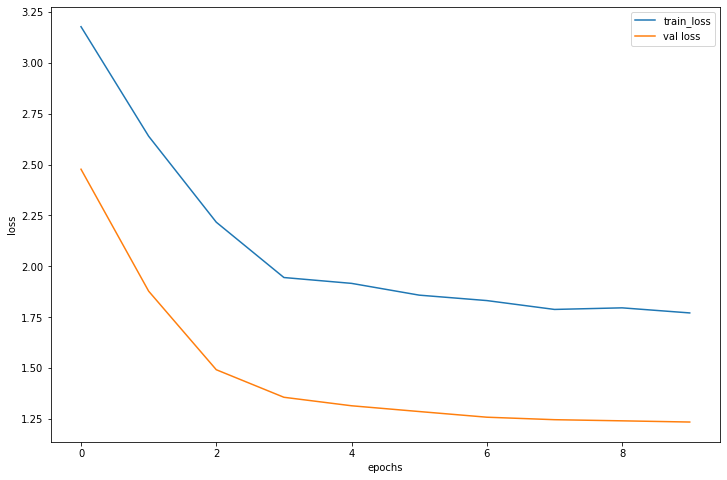

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(simple_cnn, imgs)

In [ ]:
y_pred = np.argmax(probs_imgs, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels, y_pred

([4, 4, 0, 0, 6, 4, 0, 0, 5, 6, 6, 6, 4, 4, 6, 0, 4, 4, 6, 4],
 array([ 4,  4,  0,  0, 27, 22, 22,  0, 17,  6,  6,  6, 15, 20,  6, 27,  4,
         4,  6,  4]))

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.65

Оценка f1 простой cnn показала максимум 0.7 <br>
<b>SimpleCNN:</b><br>
-optimizer = Adam<br>
-learning rate = 0.001<br>
-sheduler = use <br>
-bath size = 128<br>
-epochs = 5<br>
-criterion = nn.CrossEntropyLoss()<br>
-Data Augmentation = use<br>
-Баланс классов (метод OverSampling)<br>

С эксперементами над простой сверточной сетью, я думаю, можно закончить. ✅<br>
*Выше **0.7 оценки f1_scrore** добиться не удалось*.<br>
Тем не менее мы применили **augmentation данных**,
попробовали разную **вероятность появления классов** при обучении,попрактиковались с методом **OverSampling**, который, кстати,
дал *лучший результат* и помог хоть раз, но предсказать каждого героя, чего у нас до этого не было.

<font size = 10> Эпизод 6</font> <br>


---


<font size = 6>Сила глубоких сетей</font> <br>


## VGG16

In [37]:
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [38]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=42, bias=True)

In [40]:
# установим сколько слоев будем замораживать.
layers_to_unfreeze = 20
print(model.features[:-layers_to_unfreeze])

for param in model.features[:-layers_to_unfreeze].parameters():
  param.requires_grad = False

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [41]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=True)
train_dataset = SimpsonsDataset(new_train_files, mode='train', full_transform=True)

In [42]:
%%time
model.to(DEVICE)

BATCH_SIZE = 128
history_vgg = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=BATCH_SIZE, freeze=True)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/132 [00:00<?, ?it/s]

loss 2.892496531755482


epoch:  10%|█         | 1/10 [04:07<37:07, 247.47s/it]


Epoch 001 train_loss: 2.8925     val_loss 1.9178 train_acc 0.2382 val_acc 0.5321


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.8169395754908133


epoch:  20%|██        | 2/10 [08:08<32:29, 243.71s/it]


Epoch 002 train_loss: 1.8169     val_loss 1.2451 train_acc 0.5172 val_acc 0.6699


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.4693957771341912


epoch:  30%|███       | 3/10 [12:10<28:19, 242.77s/it]


Epoch 003 train_loss: 1.4694     val_loss 1.0618 train_acc 0.6011 val_acc 0.7107


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.1874887775972631


epoch:  40%|████      | 4/10 [16:09<24:08, 241.46s/it]


Epoch 004 train_loss: 1.1875     val_loss 0.9011 train_acc 0.6766 val_acc 0.7558


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.0947443632763425


epoch:  50%|█████     | 5/10 [20:10<20:05, 241.07s/it]


Epoch 005 train_loss: 1.0947     val_loss 0.8720 train_acc 0.7022 val_acc 0.7637


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.0586164883093991


epoch:  60%|██████    | 6/10 [24:10<16:03, 240.94s/it]


Epoch 006 train_loss: 1.0586     val_loss 0.8364 train_acc 0.7049 val_acc 0.7753


  0%|          | 0/132 [00:00<?, ?it/s]

loss 1.0195255732917334


epoch:  70%|███████   | 7/10 [28:10<12:02, 240.72s/it]


Epoch 007 train_loss: 1.0195     val_loss 0.8037 train_acc 0.7189 val_acc 0.7843


  0%|          | 0/132 [00:00<?, ?it/s]

loss 0.9886514809753246


epoch:  80%|████████  | 8/10 [32:11<08:01, 240.56s/it]


Epoch 008 train_loss: 0.9887     val_loss 0.8003 train_acc 0.7243 val_acc 0.7843


  0%|          | 0/132 [00:00<?, ?it/s]

loss 0.9633764446716614


epoch:  90%|█████████ | 9/10 [36:11<04:00, 240.55s/it]


Epoch 009 train_loss: 0.9634     val_loss 0.7978 train_acc 0.7316 val_acc 0.7839


  0%|          | 0/132 [00:00<?, ?it/s]

loss 0.9844114282244795


epoch: 100%|██████████| 10/10 [40:12<00:00, 241.24s/it]


Epoch 010 train_loss: 0.9844     val_loss 0.7948 train_acc 0.7257 val_acc 0.7860
CPU times: user 39min 48s, sys: 21.1 s, total: 40min 10s
Wall time: 40min 12s


In [43]:
loss, acc, val_loss, val_acc = zip(*history_vgg)

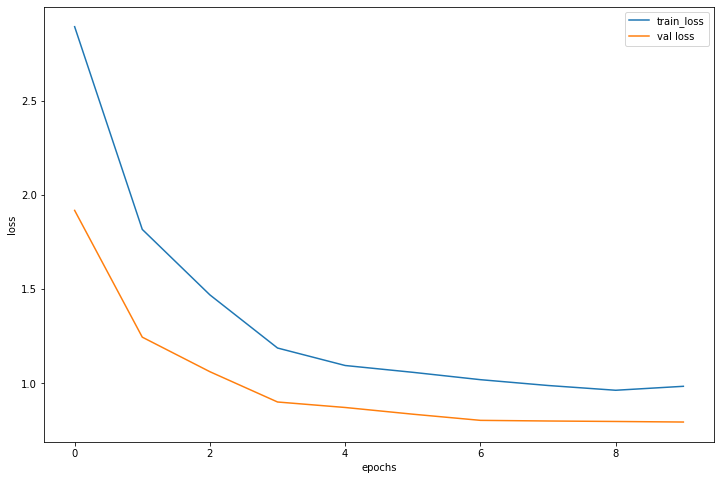

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [45]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(model, imgs)

In [48]:
y_pred = np.argmax(probs_imgs, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels, y_pred

([4, 4, 4, 2, 4, 4, 0, 2, 4, 0, 4, 2, 6, 6, 4, 4, 6, 6, 4, 0],
 array([25,  4,  4,  2, 20, 15,  0,  2,  4,  0, 37,  2,  6,  6,  4, 25,  6,
         6,  4,  0]))

In [49]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.75

<b>VGG16 c 9 незамороженными слоями </b>показывает пока что лучший результат для <b>val_acc = 0.8017</b><br> и при этом пока что лучший результат <b>f1_score = 0.95</b>

<b>VGG16:</b><br>
-optimizer = Adam<br>
-learning rate = 0.001<br>
-sheduler = use <br>
-bath size = 128<br>
-epochs = 5<br>
-criterion = nn.CrossEntropyLoss()<br>
-Data Augmentation = use<br>
-Баланс классов (метод OverSampling)<br>
-незамороженных = 9<br>
-val_acc = 0.8017<br>
-f1_score = 0.95 - максимум, который я получил<br>
-Wall time: 16min 57s

##ResNet

In [50]:
model = models.resnet152(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [51]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [52]:
list(model.fc.parameters())

[Parameter containing:
 tensor([[-0.0344, -0.0397,  0.0015,  ..., -0.0339,  0.0036, -0.0126],
         [-0.0040,  0.0011,  0.0142,  ..., -0.0224,  0.0106,  0.0008],
         [ 0.2313, -0.0163, -0.0023,  ..., -0.0143, -0.0250, -0.0100],
         ...,
         [-0.0252, -0.0118,  0.1775,  ..., -0.0156,  0.1412,  0.0141],
         [ 0.0433,  0.0254,  0.0226,  ...,  0.0019, -0.0160, -0.0388],
         [-0.0364,  0.0367, -0.0369,  ..., -0.0099, -0.0021, -0.0120]],
        requires_grad=True), Parameter containing:
 tensor([-1.2052e-02, -9.4437e-03, -1.5197e-02, -1.6984e-02,  1.3197e-02,
          5.5471e-03, -1.7660e-02,  2.0176e-03,  9.0741e-03, -4.7870e-03,
         -1.1567e-02, -5.4762e-03, -2.0325e-02, -1.5016e-02, -1.5727e-02,
         -1.6399e-02, -1.2998e-02, -1.3455e-02,  1.1179e-02, -1.3863e-02,
          6.9889e-03,  2.7044e-02,  2.1685e-04,  1.6292e-03, -2.6509e-03,
          6.4799e-03,  1.4415e-02, -4.7806e-03, -2.4253e-03, -1.8473e-02,
         -5.4992e-03, -8.7497e-03, -3.784

In [53]:
model.fc = nn.Linear(in_features=2048, out_features=42, bias=True)

In [54]:
for param in model.layer1.parameters():
  param.requires_grad = False

for i in model.layer2.parameters():
  param.requires_grad = False

for i in model.layer3.parameters():
  param.requires_grad = False

In [55]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=True)
train_dataset = SimpsonsDataset(new_train_files, mode='train', full_transform=True)

In [56]:
%%time
torch.cuda.empty_cache()
model.to(DEVICE)

BATCH_SIZE = 16
history_vgg = train(train_dataset, val_dataset, model=model, epochs=5, batch_size=BATCH_SIZE, freeze='ResNet')

epoch:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/1056 [00:00<?, ?it/s]

loss 1.3140708623182213


epoch:  20%|██        | 1/5 [07:11<28:47, 431.85s/it]


Epoch 001 train_loss: 1.3141     val_loss 0.3659 train_acc 0.6664 val_acc 0.9085


  0%|          | 0/1056 [00:00<?, ?it/s]

loss 0.9116819482198584


epoch:  40%|████      | 2/5 [14:14<21:18, 426.23s/it]


Epoch 002 train_loss: 0.9117     val_loss 0.3208 train_acc 0.7559 val_acc 0.9150


  0%|          | 0/1056 [00:00<?, ?it/s]

loss 0.6216995228762173


epoch:  60%|██████    | 3/5 [21:16<14:08, 424.49s/it]


Epoch 003 train_loss: 0.6217     val_loss 0.2369 train_acc 0.8349 val_acc 0.9421


  0%|          | 0/1056 [00:00<?, ?it/s]

loss 0.4160453597042896


epoch:  80%|████████  | 4/5 [28:17<07:03, 423.23s/it]


Epoch 004 train_loss: 0.4160     val_loss 0.1713 train_acc 0.8912 val_acc 0.9564


  0%|          | 0/1056 [00:00<?, ?it/s]

loss 0.38469479357678754


epoch: 100%|██████████| 5/5 [35:18<00:00, 423.77s/it]


Epoch 005 train_loss: 0.3847     val_loss 0.1591 train_acc 0.8979 val_acc 0.9601
CPU times: user 30min 20s, sys: 4min 49s, total: 35min 10s
Wall time: 35min 19s


In [57]:
loss, acc, val_loss, val_acc = zip(*history_vgg)

In [58]:
idxs = list(map(int, np.random.uniform(0, 1000, 1000)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(model, imgs)

In [59]:
y_pred = np.argmax(probs_imgs, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels, y_pred

([6,
  0,
  0,
  4,
  4,
  4,
  6,
  6,
  0,
  6,
  6,
  4,
  6,
  4,
  0,
  0,
  4,
  6,
  0,
  0,
  4,
  0,
  0,
  6,
  0,
  6,
  0,
  4,
  0,
  4,
  6,
  3,
  3,
  0,
  4,
  2,
  2,
  4,
  4,
  2,
  0,
  2,
  2,
  6,
  0,
  4,
  4,
  6,
  4,
  0,
  0,
  2,
  4,
  4,
  4,
  6,
  2,
  0,
  6,
  4,
  4,
  0,
  4,
  6,
  4,
  6,
  4,
  4,
  6,
  6,
  4,
  0,
  4,
  4,
  5,
  4,
  6,
  0,
  2,
  0,
  4,
  2,
  0,
  4,
  6,
  6,
  0,
  2,
  3,
  5,
  4,
  2,
  4,
  0,
  6,
  2,
  0,
  0,
  2,
  2,
  0,
  2,
  4,
  6,
  0,
  0,
  4,
  6,
  4,
  6,
  6,
  4,
  6,
  0,
  0,
  0,
  0,
  6,
  0,
  0,
  6,
  0,
  6,
  0,
  0,
  4,
  4,
  6,
  2,
  2,
  0,
  2,
  4,
  3,
  0,
  4,
  6,
  4,
  4,
  0,
  4,
  2,
  4,
  6,
  0,
  0,
  0,
  2,
  6,
  4,
  2,
  2,
  0,
  2,
  2,
  6,
  4,
  6,
  3,
  4,
  0,
  4,
  2,
  0,
  0,
  2,
  0,
  2,
  0,
  4,
  4,
  4,
  4,
  6,
  0,
  4,
  0,
  4,
  4,
  0,
  4,
  0,
  2,
  6,
  0,
  0,
  2,
  0,
  4,
  0,
  4,
  2,
  3,
  6,
  0,
  2,
  4,
  3,
  4,
  0,


In [60]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.968

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test", full_transform=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
#my_submit = pd.read_csv("/content/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('labels.csv', index=False)
my_submit.head()